## Kassandra model training 

### Disclaimer: This is example of Kassandra deconvolution alghorithm training described in the original publication (link). To make model training handable with reasonable amount of compute here we provide smaller version of the model with the subset of data used in the publication. However model training still require significant computational resources (4 cores, ~30gb RAM). The performance of the model may significantly differ from one in the publication. The example is provide solely for educational purposes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image
from core.mixer import Mixer
from core.cell_types import CellTypes
from core.model import DeconvolutionModel
from core.plotting import print_cell_matras, cells_p, print_all_cells_in_one

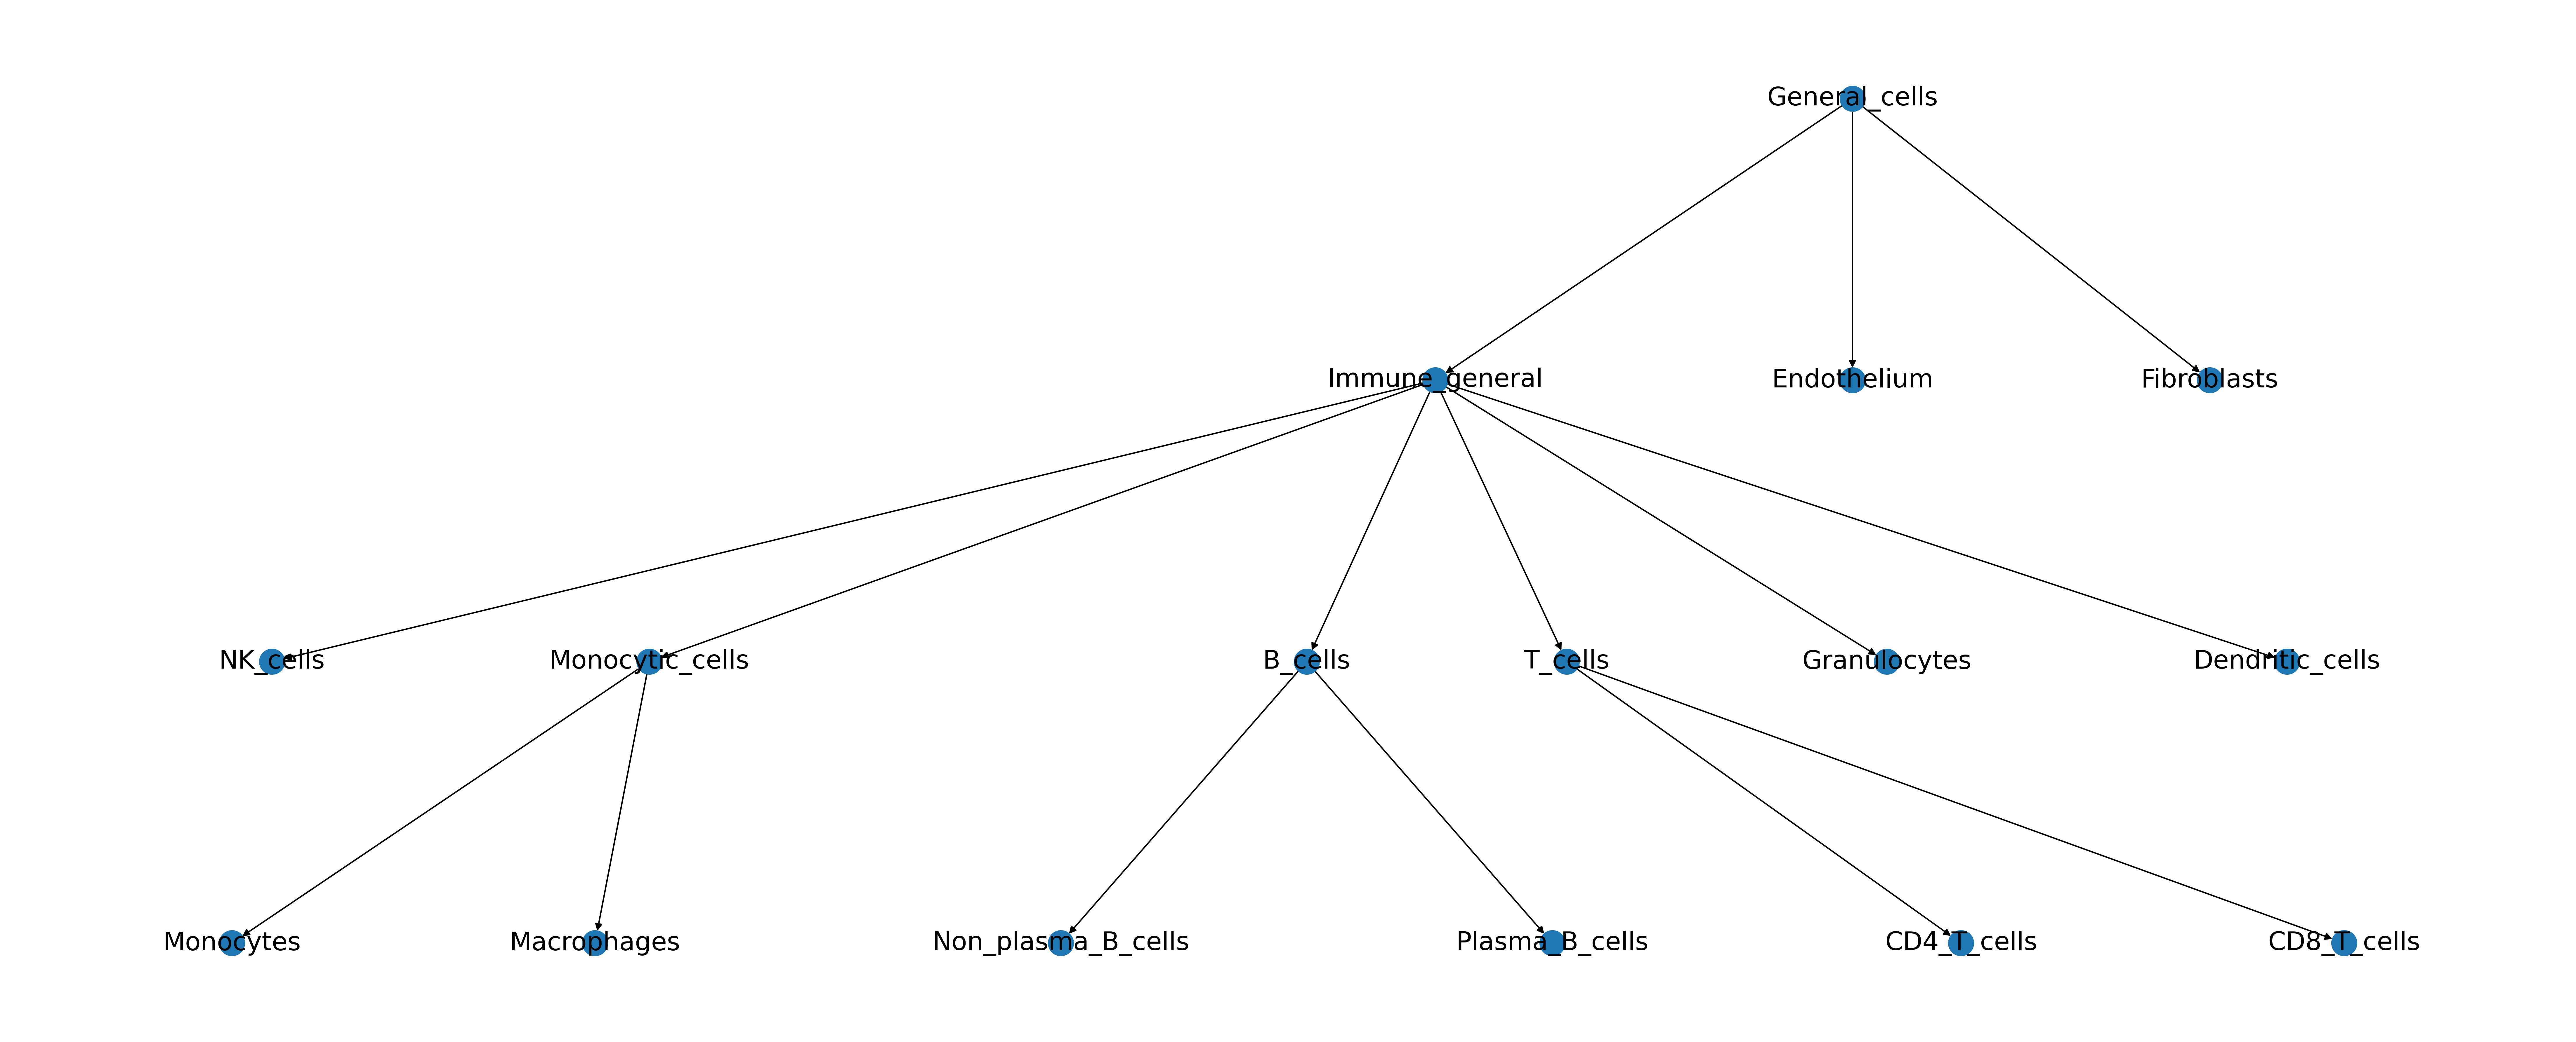

In [2]:
Image(filename='data/tree.png')

In [3]:
cancer_sample_annot = pd.read_csv('data/cancer_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cancer_expr = pd.read_csv('data/cancer_expr.tsv.tar.gz', sep='\t', index_col=0)
cells_sample_annot = pd.read_csv('data/cells_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cells_expr = pd.read_csv('data/cells_expr.tsv.tar.gz', sep='\t', index_col=0)

In [4]:
# Pseudobulk generation
cell_types = CellTypes.load('configs/cell_types.yaml')
mixer = Mixer(cell_types=cell_types,
              cells_expr=cells_expr, cells_annot=cells_sample_annot,
              tumor_expr=cancer_expr, tumor_annot=cancer_sample_annot,
              num_av=3, num_points=30)
expr, values = mixer.generate('Immune_general')
values

Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Endothelium,0.023454,0.024659,0.110977,0.152461,0.032828,0.010406,0.007611,0.147171,0.097470,0.280600,...,0.382485,0.020425,0.008275,0.429309,0.121999,0.417742,0.097454,0.463923,0.147464,0.002033
Fibroblasts,0.138098,0.032823,0.031733,0.236491,0.092934,0.095333,0.003802,0.128006,0.036741,0.376199,...,0.003660,0.219794,0.294266,0.199688,0.009969,0.025720,0.331316,0.064945,0.000064,0.018809
Immune_general,0.024569,0.341165,0.053349,0.011118,0.045649,0.049022,0.009111,0.206980,0.733344,0.039754,...,0.179135,0.153627,0.483912,0.270718,0.266598,0.264195,0.081512,0.134941,0.082979,0.336849
Tumor,0.813880,0.601353,0.803941,0.599930,0.828589,0.845239,0.979476,0.517842,0.132446,0.303447,...,0.434720,0.606155,0.213548,0.100284,0.601434,0.292342,0.489718,0.336191,0.769492,0.642309


In [5]:
# Model training
mixer = Mixer(cell_types=cell_types,
              cells_expr=cells_expr, cells_annot=cells_sample_annot,
              tumor_expr=cancer_expr, tumor_annot=cancer_sample_annot,
              num_av=3, num_points=30000)

model = DeconvolutionModel(cell_types,
                           boosting_params_first_step='configs/boosting_params/lgb_parameters_first_step.tsv',
                           boosting_params_second_step='configs/boosting_params/lgb_parameters_second_step.tsv')
model.fit(mixer)

Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK
==============L1 models==============
Fitting B_cells model
Fitting CD4_T_cells model
Fitting CD8_T_cells model
Fitting Dendritic_cells model
Fitting Endothelium model
Fitting Fibroblasts model
Fitting Granulocytes model
Fitting Immune_general model
Fitting Macrophages model
Fitting Monocytes model
Fitting Monocytic_cells model
Fitting NK_cells model
Fitting Non_plasma_B_cells model
Fitting Plasma_B_cells model
Fitting T_cells model
==============L2 models==============
Fitting B_cells model
Fitting CD4_T_cells model
Fitting CD8_T_cells model
Fitting Dendritic_cells model
Fitting Endothelium model
Fitting Fibroblasts model
Fitting Granulocytes model
Fitting Immune_general model
Fitting Macrophages model
Fitting Monocytes model
Fitting Monocytic_cells model
Fitting NK_cells model
Fitting Non_plasma_B_cells model
Fitting Plasma_B_cells model
Fitting T_cells model


Expressions OK


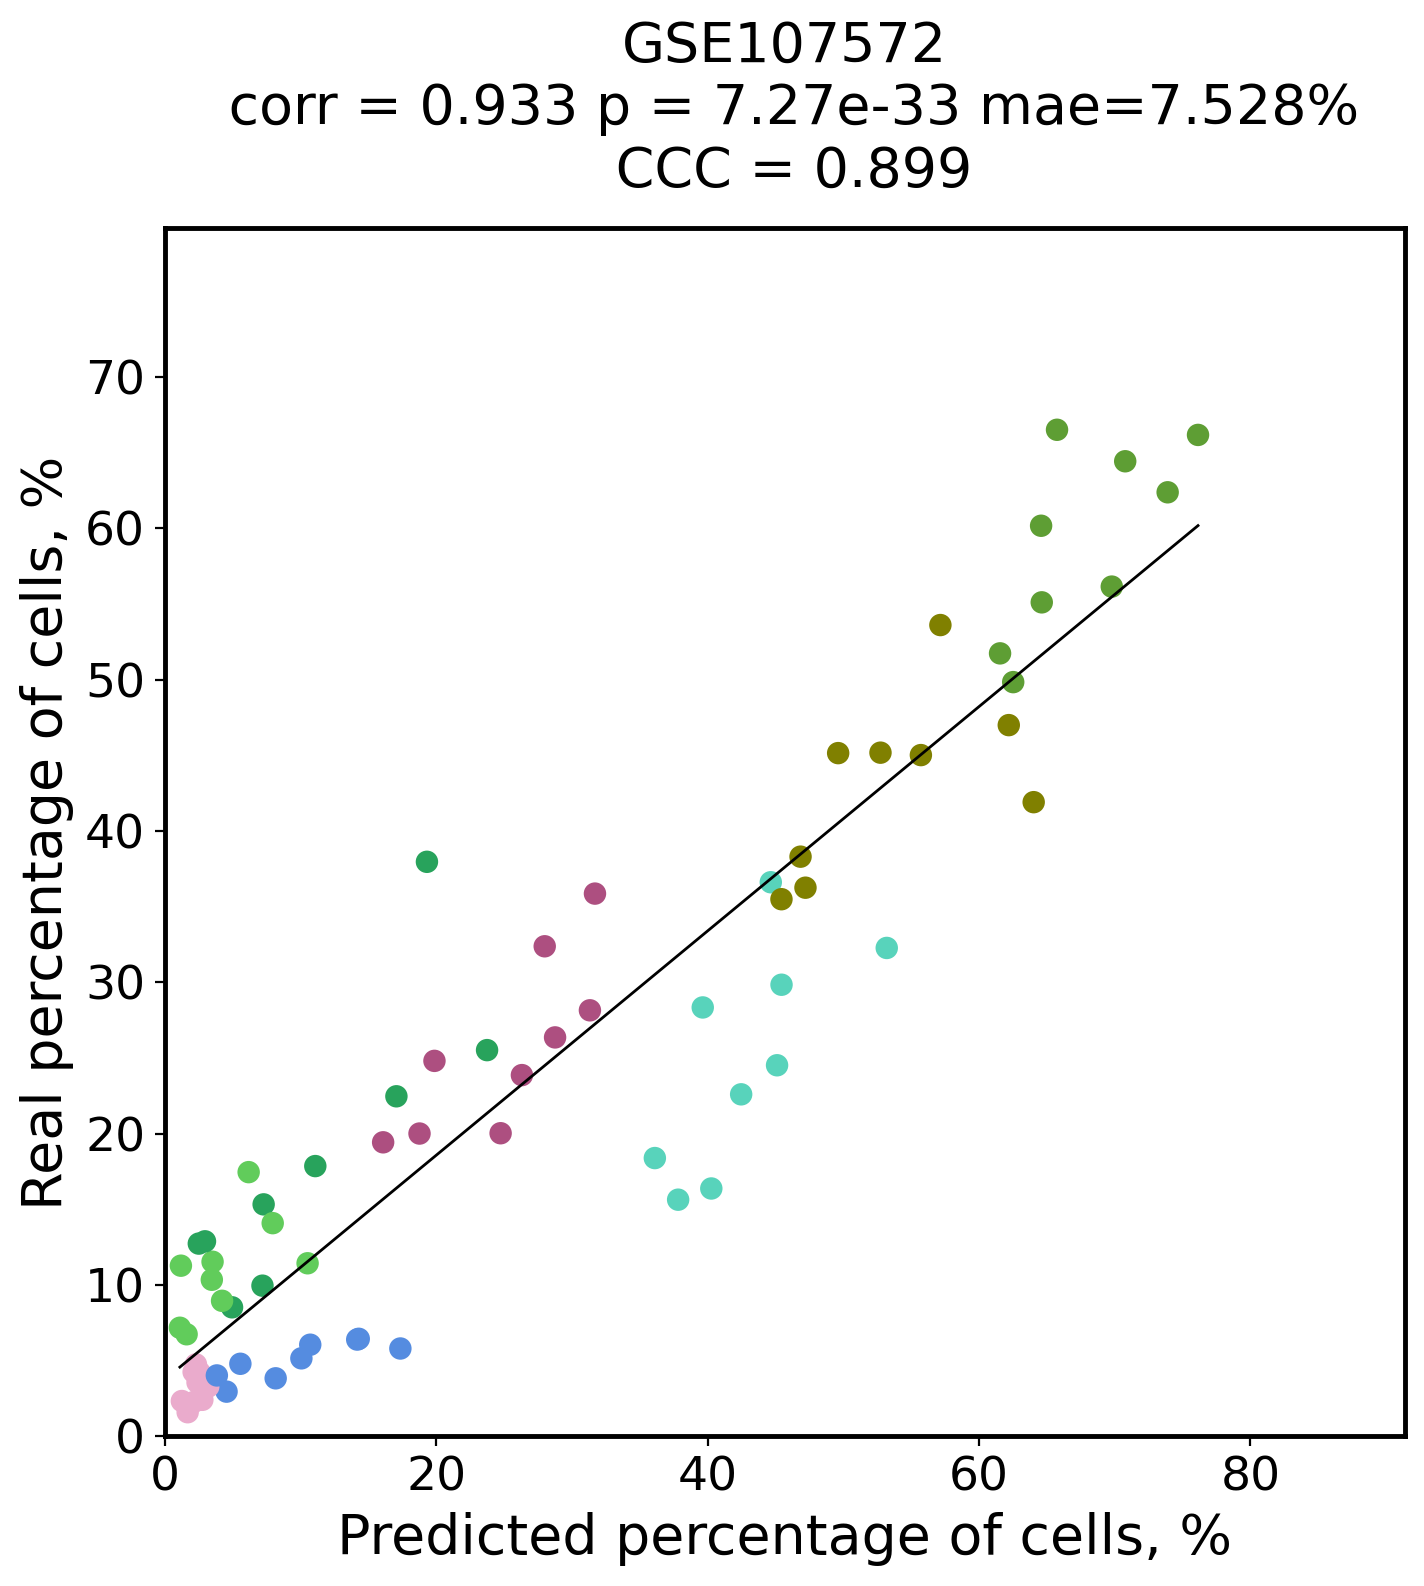

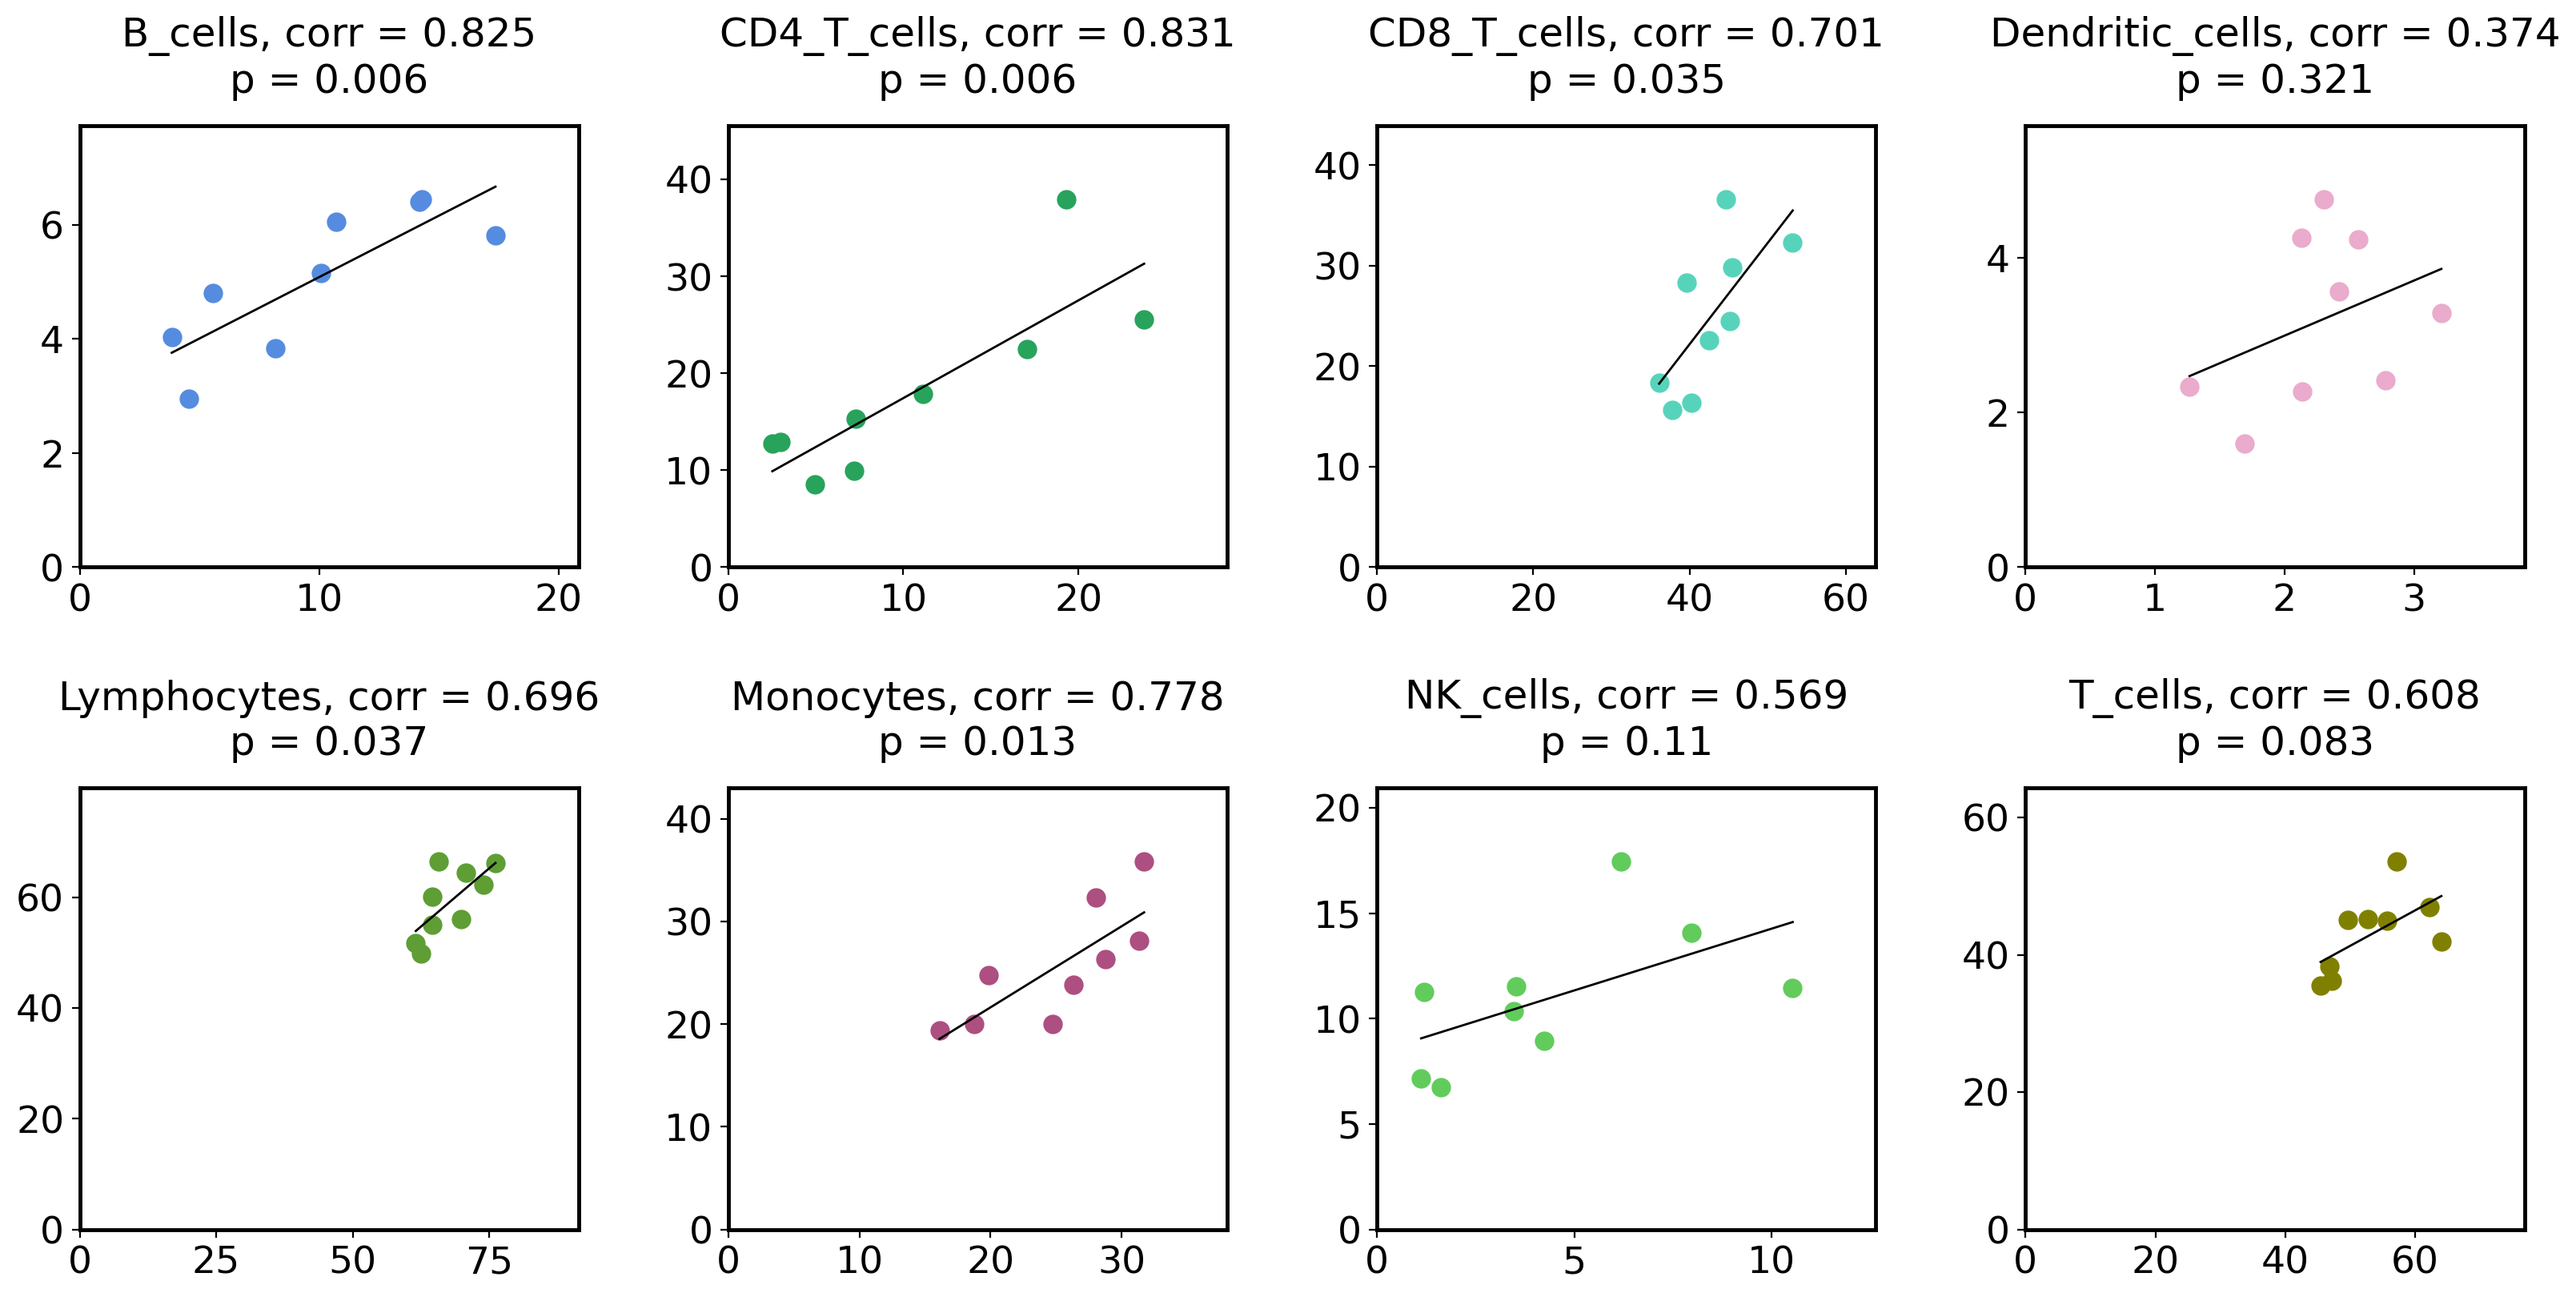

In [7]:
# Performance testing
dataset = 'GSE107572'
cytof = pd.read_csv('data/GSE107572_cytof.tsv.tar.gz', sep='\t', index_col=0)
expr = pd.read_csv('data/GSE107572_expr.tsv.tar.gz', sep='\t', index_col=0)

preds = model.predict(expr) * 100
preds.loc['Lymphocytes'] = preds.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

plt.rcParams['figure.dpi'] = 200
plt.rcParams["axes.edgecolor"] = "0.0"
plt.rcParams["axes.linewidth"]  = 1.75

x = print_all_cells_in_one(preds, 
                           cytof,
                           pallete=cells_p,
                           title=dataset, min_xlim=0, min_ylim=0)

x = print_cell_matras(preds, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='', predicted_name='',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=4, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)

Expressions OK


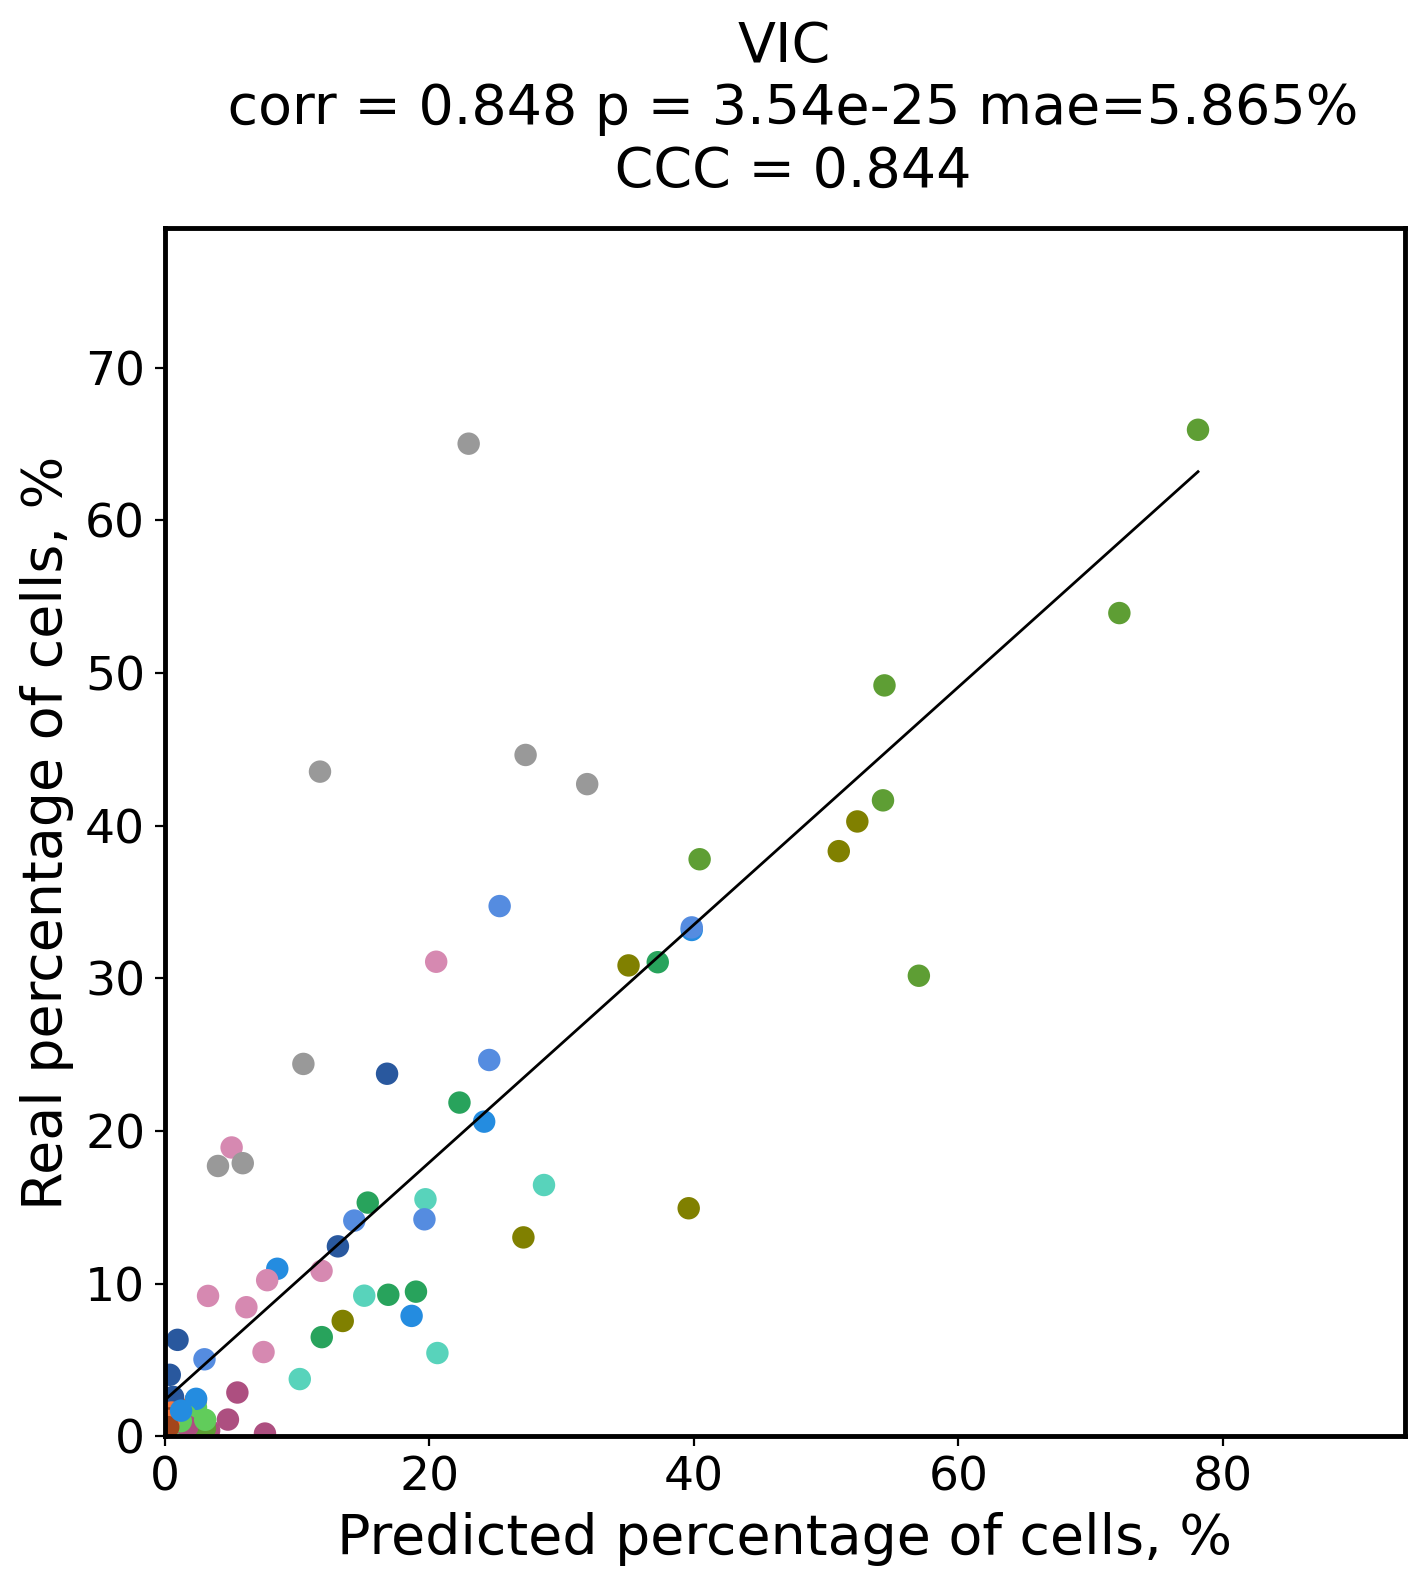

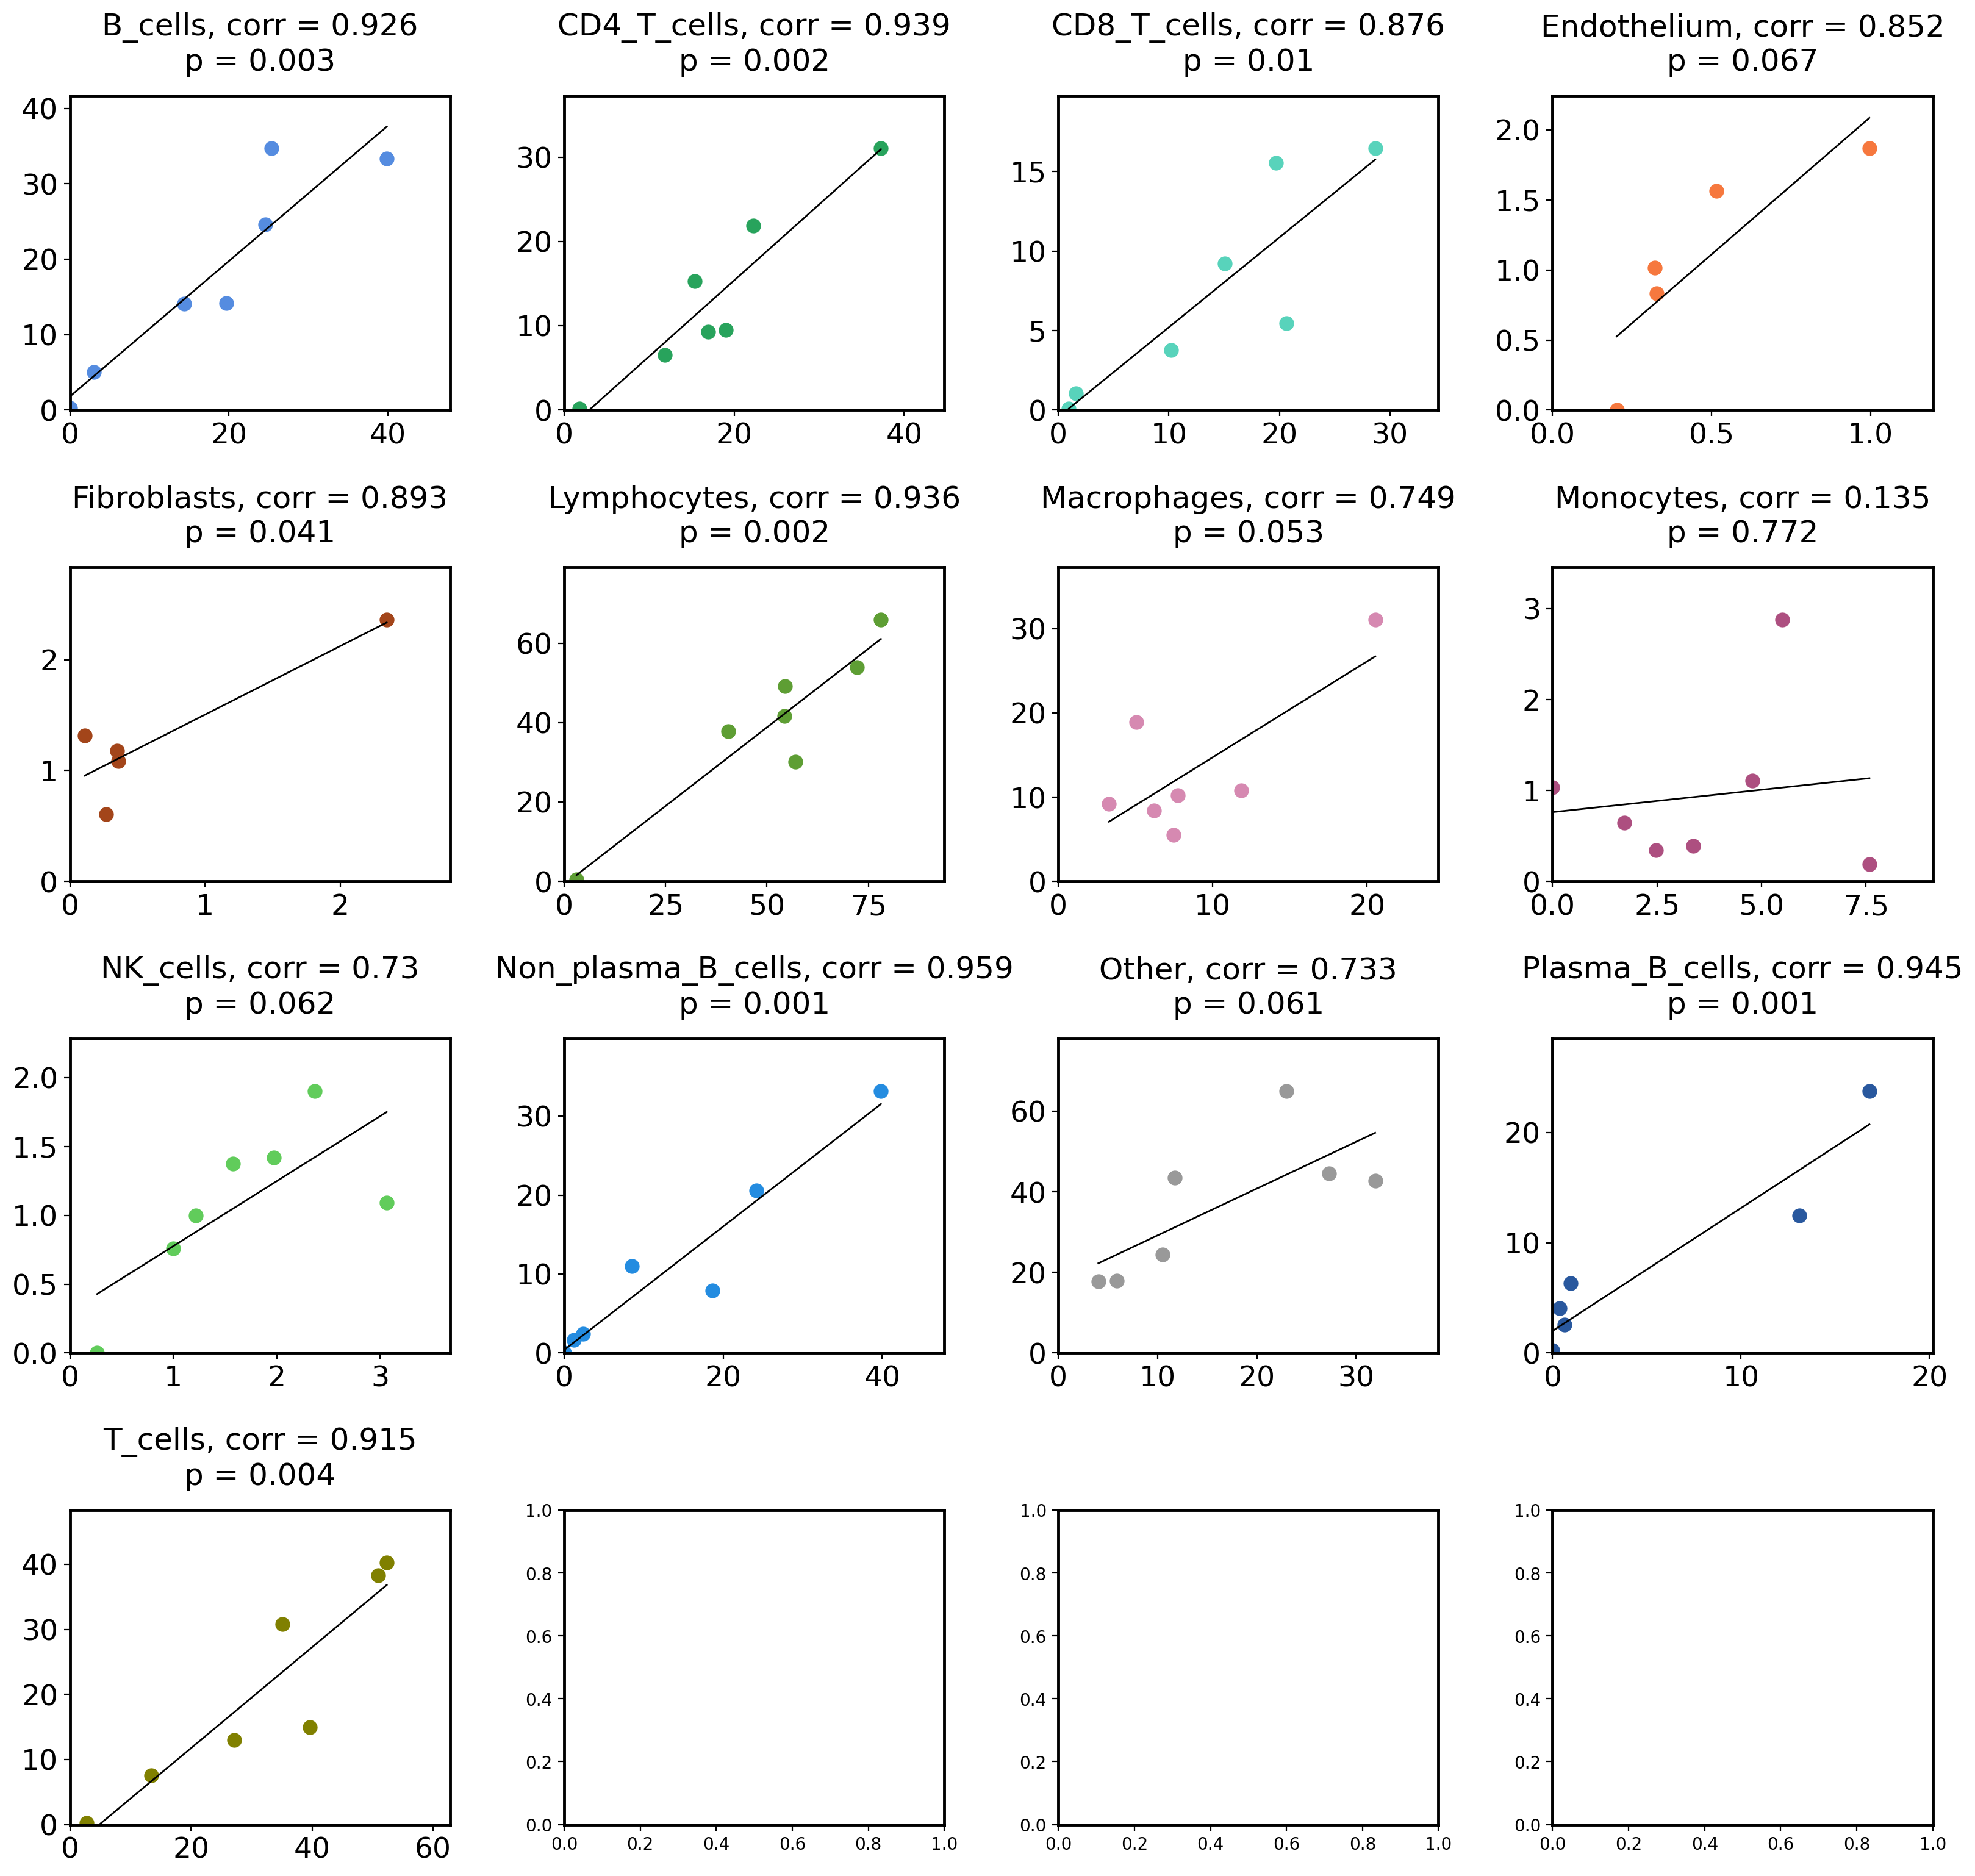

In [6]:
dataset = 'VIC'
cytof = pd.read_csv('data/VIC_cytof.tsv.tar.gz', sep='\t', index_col=0)
expr = pd.read_csv('data/VIC_expr.tsv.tar.gz', sep='\t', index_col=0)

preds = model.predict(expr) * 100
preds.loc['Lymphocytes'] = preds.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

plt.rcParams['figure.dpi'] = 200
plt.rcParams["axes.edgecolor"] = "0.0"
plt.rcParams["axes.linewidth"]  = 1.75

x = print_all_cells_in_one(preds, 
                           cytof,
                           pallete=cells_p,
                           title=dataset, min_xlim=0, min_ylim=0)

x = print_cell_matras(preds, cytof,
                  pallete=cells_p, colors_by='index', title='',
                  true_name='', predicted_name='',
                  sub_title_font=18, fontsize_title=30,
                  subplot_ncols=4, ticks_size=17, wspace=0.3, hspace=0.5, min_xlim=0, min_ylim=0)